# Boston Housing Dataset - Regression Analysis

This notebook performs a comprehensive analysis of the Boston Housing dataset, including data preprocessing, exploratory data analysis (EDA), model training (Decision Tree, Random Forest), and implementation of Ridge Regression from scratch.

---

## 1. Loading the Boston Housing Dataset

The dataset is sourced from:  
http://lib.stat.cmu.edu/datasets/boston

- It contains **506 samples** and **14 variables** (13 features + 1 target).
- Each data point is split across two lines, and this must be corrected before loading.


In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Define column names based on the dataset description
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

# Fetch the raw data from the StatLib URL
url = 'http://lib.stat.cmu.edu/datasets/boston'
response = requests.get(url)
lines = response.text.splitlines()

# Skip the first 22 lines (metadata) and process the data
data_lines = lines[22:]

# Combine every two lines into one, as each observation is split across two lines
combined_lines = []
for i in range(0, len(data_lines), 2):
    if i + 1 < len(data_lines):  # Ensure there's a second line
        combined_lines.append(data_lines[i] + ' ' + data_lines[i + 1])

# Convert the combined lines into a format pandas can read
data_text = '\n'.join(combined_lines)
data = pd.read_csv(StringIO(data_text), delim_whitespace=True, names=columns)

# Display the first few rows
data.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


---

## 2. Variable Descriptions

The following are the variables in the dataset:

- **CRIM**: per capita crime rate by town
- **ZN**: proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS**: proportion of non-retail business acres per town
- **CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **NOX**: nitric oxides concentration (parts per 10 million)
- **RM**: average number of rooms per dwelling
- **AGE**: proportion of owner-occupied units built prior to 1940
- **DIS**: weighted distances to five Boston employment centres
- **RAD**: index of accessibility to radial highways
- **TAX**: full-value property-tax rate per 10,000 dollars
- **PTRATIO**: pupil-teacher ratio by town
- **B**: 1000(Bk - 0.63)^2 where Bk is the proportion of Black residents
- **LSTAT**: % lower status of the population
- **MEDV**: Median value of owner-occupied homes in $1000's

---

## 3. Exploratory Data Analysis (EDA)

The goal is to understand the distribution, skewness, outliers, and relationships among features and the target variable.


In [3]:
# Check the Data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [4]:
data.shape

(506, 14)

---

### 3.1 Summary Statistics


In [5]:
# 1. Summary Statistics
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Observations:
- **CRIM: Per capita crime rate by town**  
  - Most crime rates (about 75%) hover between 0 and 4, but the maximum of 88 stands out, hinting at a potential outlier that might skew the data.
- **ZN: Proportion of residential land zoned for lots over 25,000 sq.ft.**  
  - Over half the areas have no land zoned for large lots (0%), while the highest is 100%, indicating this is a scarce feature across the dataset.
- **INDUS: Proportion of non-retail business acres per town**  
  - Values range from 0.4% to 27%, with an average around 11%, showing that industrial activity is present to some degree in most towns.
- **CHAS: Charles River dummy variable (1 if tract bounds river, 0 otherwise)**  
  - With a mean of 0.069, only about 7% of the properties are near the Charles River, making it a rare characteristic.
- **NOX: Nitric Oxide concentration (parts per 10 million)**  
  - Spans from 0.38 to 0.87, averaging 0.55, with a distribution that appears fairly normal.
- **RM: Average number of rooms per dwelling**  
  - Varies between 3.5 and 8.7, with a mean of 6.2, and the distribution looks reasonably balanced.
- **AGE: Proportion of owner-occupied units built before 1940**  
  - Ranges from 2.9% to 100%, averaging 68%, with a normal distribution. The low end at 2.9% suggests no newly built homes are included.
- **DIS: Weighted distances to five Boston employment centers**  
  - Extends from 1.1 to 12.1, averaging 3.7, with a distribution that seems fairly even.
- **RAD: Index of accessibility to radial highways**  
  - Goes from 1 to 24, with over 75% hitting the maximum of 24. The big leap from the 50th percentile (5) to the 75th (24) might point to two distinct groups—rural and urban areas.
- **TAX: Full-value property-tax rate per $10,000**  
  - Ranges from 187 to 711, with an average of 408, and a normal distribution, suggesting these are homes in mid to high-income zones.
- **PTRATIO: Pupil-teacher ratio by town**  
  - Falls between 12.6 and 22, averaging 18.4, with a distribution that looks fairly consistent.
- **LSTAT: \% lower status of the population**  
  - Ranges from 7\% to 37.9\%, averaging 12\%, indicating most areas have a low proportion of lower socio-economic status. The jump from the 75th percentile (16.9\%) to the max (37\%) could signal a distinct lower-income area or a possible outlier.
- **MEDV: Median value of owner-occupied homes in \$1000's**  
  - Spans from 5k to 50k, with an average of 22k, and the distribution appears normal, though the 50k cap suggests potential censoring.



---

### 3.2 Missing Values Check


In [6]:
# 3. Missing Values
print(data.isnull().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


---

### 3.3 Univariate Analysis

We examine the distribution of the target variable and continuous features.


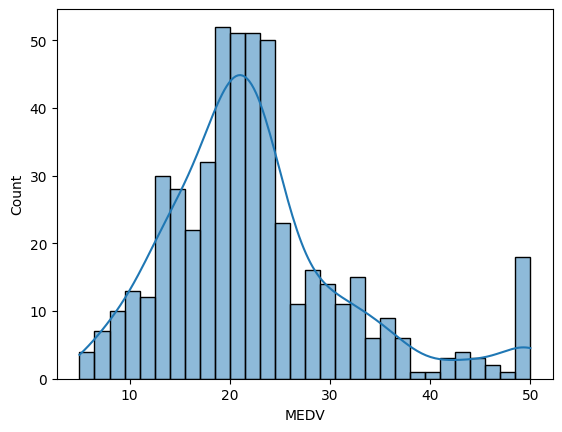

In [7]:
plt.figure()
sns.histplot(data['MEDV'], bins=30, kde = True)
plt.show()

### Observations

- The histogram of `MEDV` (Median Value of Owner-Occupied Homes) shows a right-skewed distribution.
- A significant number of observations are concentrated between $15,000 and $25,000, with a distinct spike at $50,000.

---

### 3.4 Histograms for Numeric Features
`

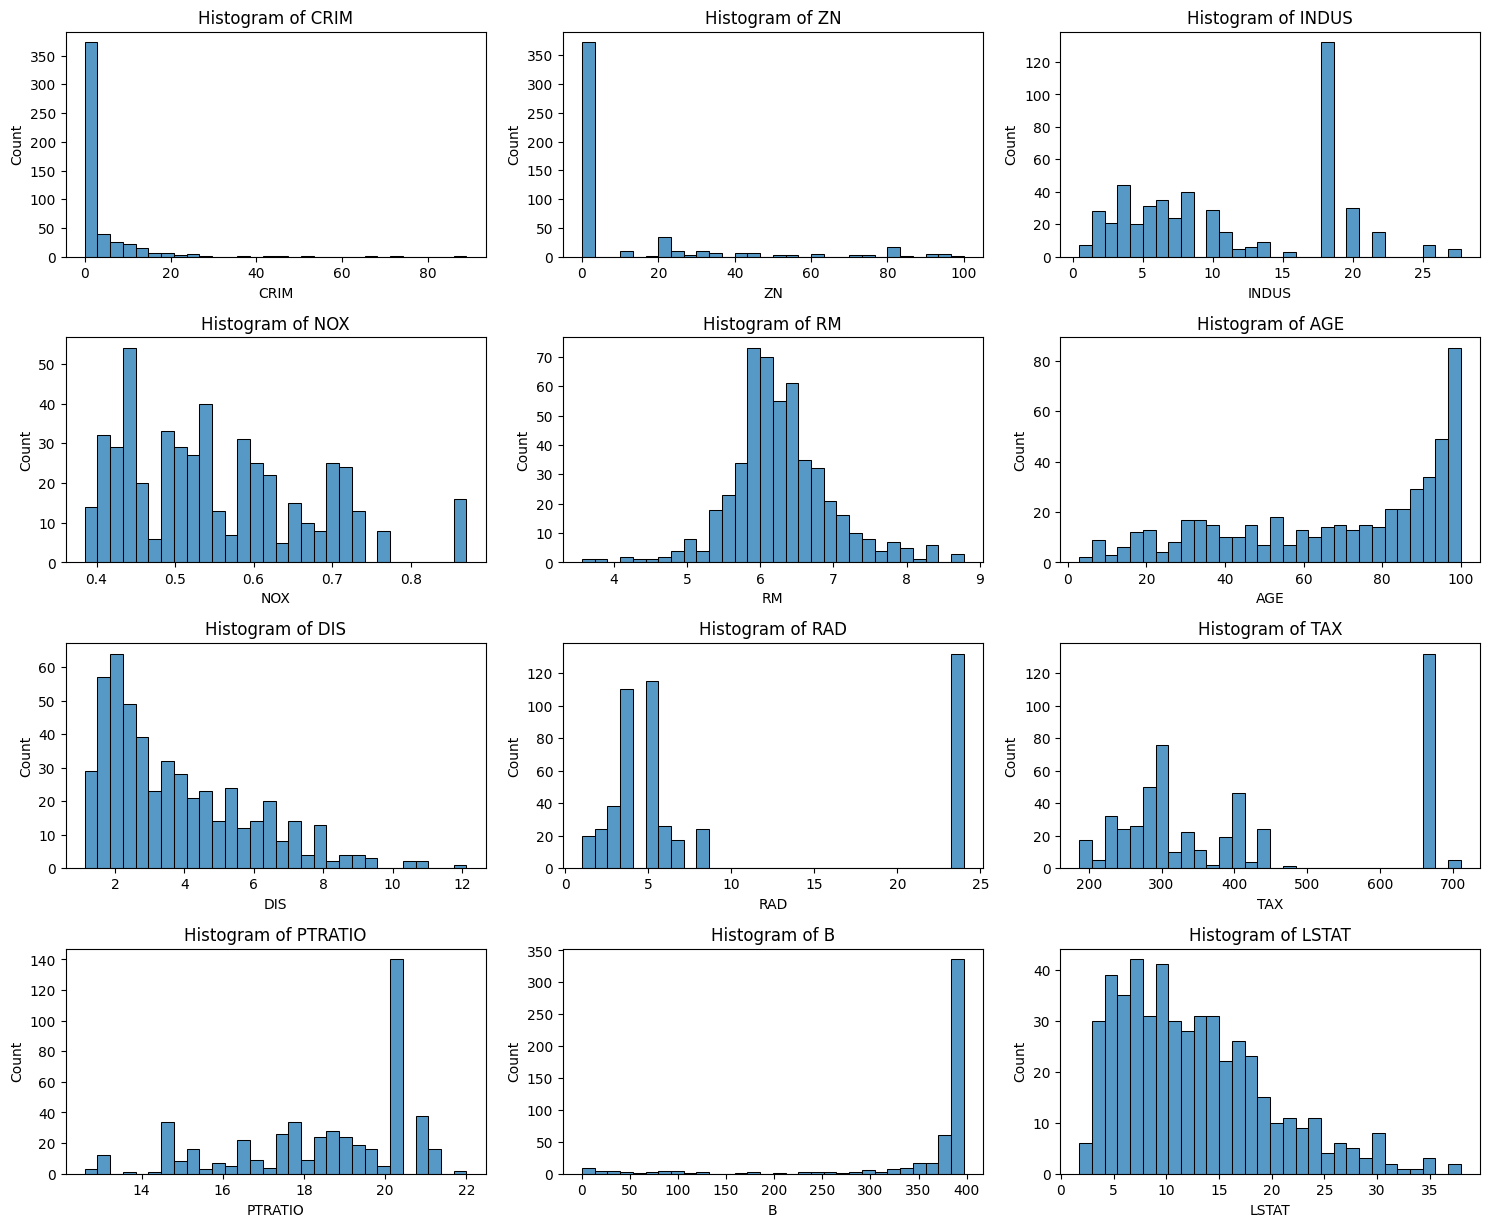

In [8]:
# 4. Distributions: Plot histograms for all features except target and 'CHAS' (as it is binary variable)
plt.figure(figsize=(15, 15))
features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)
    sns.histplot(data[feature], bins=30, kde=False)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

### observations 

- **CRIM**: Highly **right-skewed**; majority of towns have low crime rates.
- **ZN**: Over 75% of towns have 0% zoning for large lots, indicating zoning is rare and the feature is **sparse**.
- **INDUS**: Bimodal distribution indicates **two distinct types of towns**—commercial vs. residential.
- **NOX**: Skewed right; most values are under 0.6. Higher values are rare.
- **RM**: Near-normal distribution centered at ~6 rooms per dwelling, implying balanced residential design.
- **AGE**: Heavily **left-skewed**; many towns have older housing stock.
- **DIS**: Right-skewed, meaning many towns are located **closer to employment centers**.
- **RAD**: Strong spike at 24, indicating **urban clusters** with extreme highway accessibility.
- **TAX**: Bimodal with peaks around 300 and 660; this might indicate policy zoning differences across regions.
- **PTRATIO**: Uniformly distributed across 14 to 22; minimal skewness.
- **B**: Right-skewed with a strong peak near 400, indicating **most towns have high racial homogeneity**.
- **LSTAT**: Right-skewed, suggesting lower socio-economic population is a **minority in most towns**.


---

## 4. Categorical Variable Analysis

CHAS is a binary variable indicating proximity to the Charles River.


CHAS
0    471
1     35
Name: count, dtype: int64


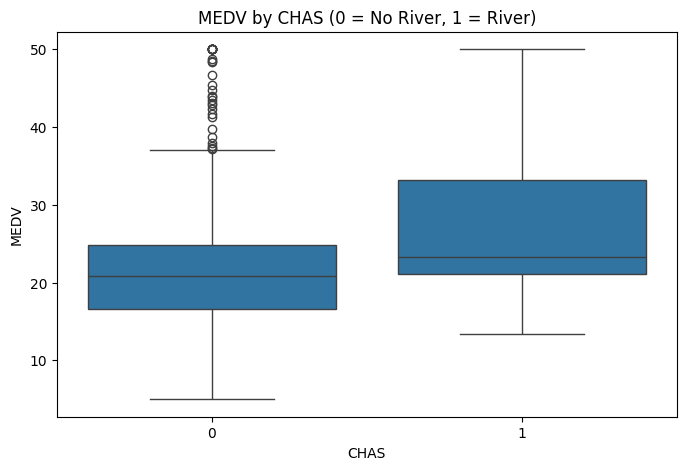

In [9]:
# CHAS Distribution and Impact on MEDV
print(data['CHAS'].value_counts())
plt.figure(figsize=(8, 5))
sns.boxplot(x='CHAS', y='MEDV', data=data)
plt.title("MEDV by CHAS (0 = No River, 1 = River)")
plt.show()

### Observations

- Properties **near the Charles River (CHAS = 1)** tend to have **higher median values**.
- However, due to the small number of such properties (only ~7%), the variable has **limited explanatory power** but could still be a valuable binary indicator.
- There are **outliers** in the CHAS=0 group with high MEDV, indicating **non-river towns** can still command high prices under specific circumstances.

---

## 5. Bivariate Analysis

Explore relationships between features and the target variable using scatter plots.


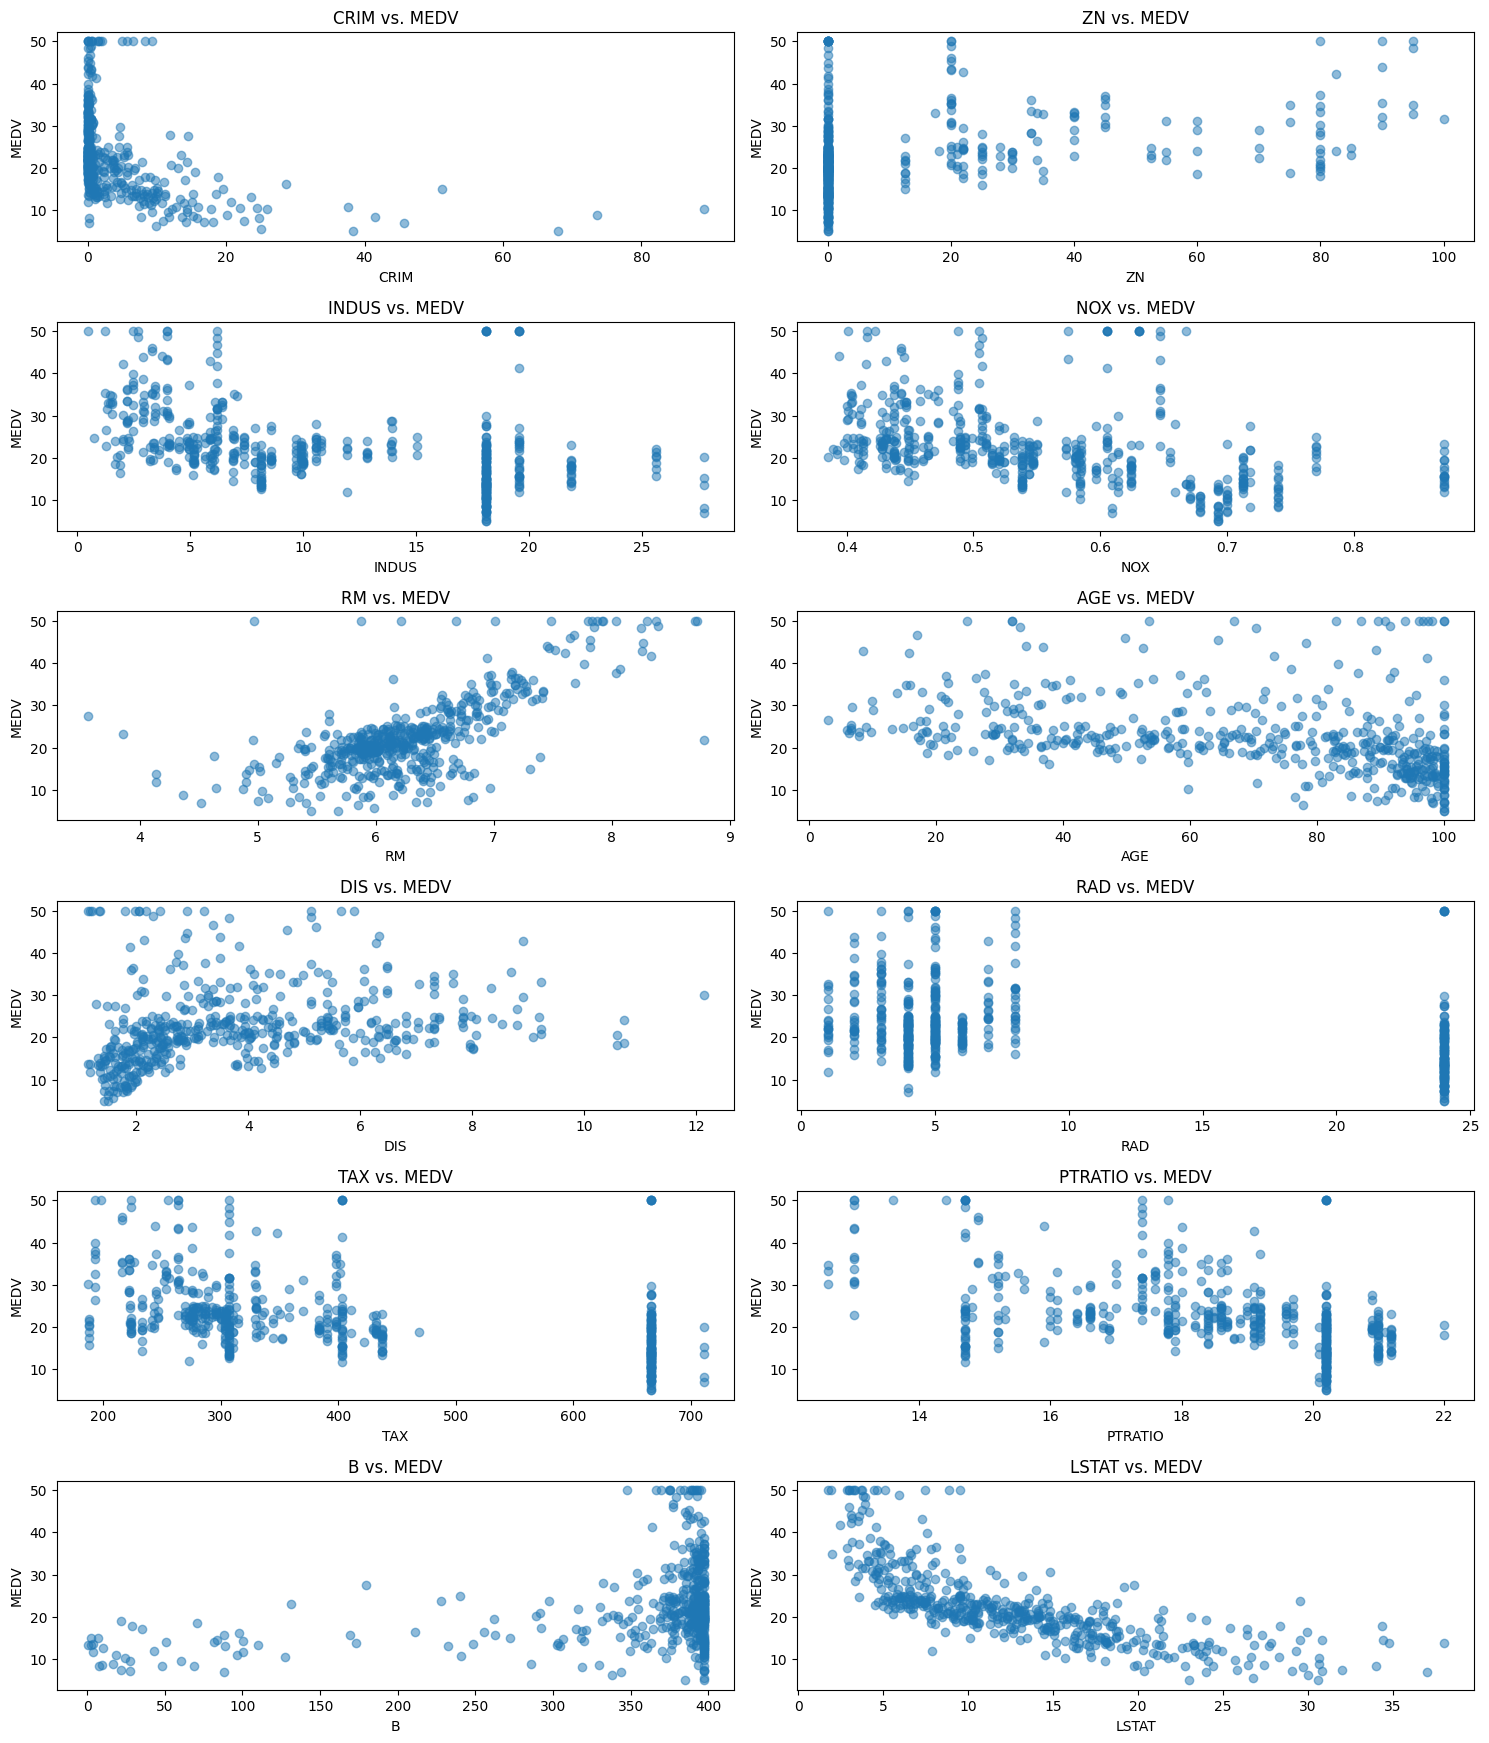

In [10]:
# 5. Scatter Plots
plt.figure(figsize=(15, 20))
for i, feature in enumerate(features, 1):
    plt.subplot(7, 2, i)
    plt.scatter(data[feature], data['MEDV'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('MEDV')
    plt.title(f'{feature} vs. MEDV')
plt.tight_layout()
plt.show()

### Observations

- **CRIM**: Inverse relationship; high crime towns typically have low house values.
- **ZN**: Weak positive trend; not strongly predictive on its own.
- **INDUS**: Mild negative correlation with MEDV.
- **NOX**: Inversely correlated; high pollution areas have lower house prices.
- **RM**: Strong **positive linear relationship**—more rooms predict higher prices.
- **AGE**: Weak inverse correlation; older buildings slightly correlate with lower prices.
- **DIS**: Positive trend, but with diminishing returns; distance may act as a **proxy for suburban affluence**.
- **RAD**: Almost no useful trend; values are heavily clustered.
- **TAX**: Noisy inverse relationship; higher taxes **might discourage** higher house values.
- **PTRATIO**: Weak negative correlation; better school systems (lower PTRATIO) might raise values.
- **B**: Very noisy pattern; unreliable as a direct predictor.
- **LSTAT**: Strong **negative non-linear** relationship; low-income population share has high predictive power for housing value.


---

## 6. Multivariate Analysis

Correlation analysis helps identify redundant features and strong predictors.


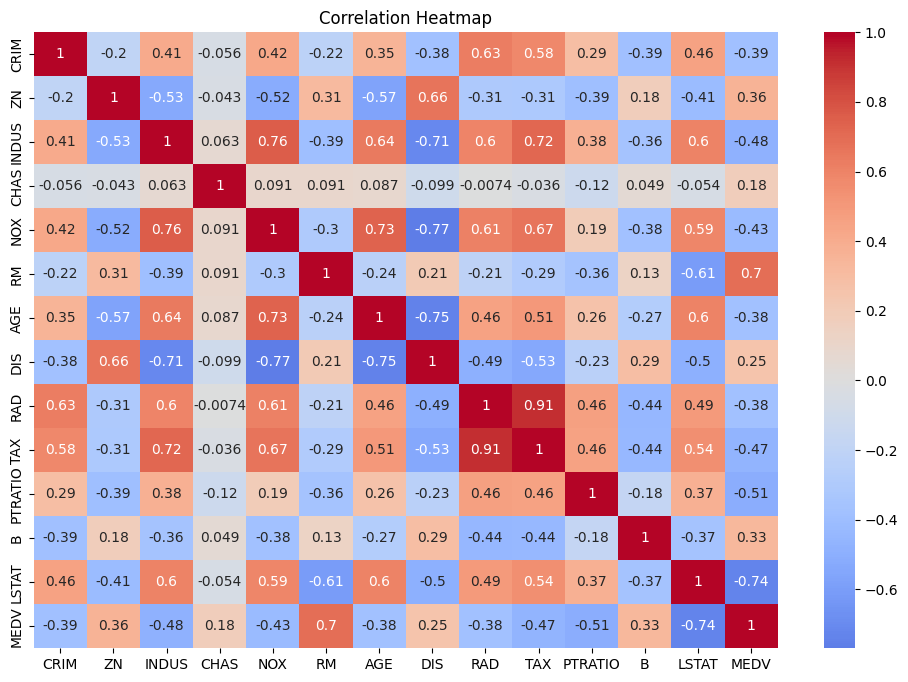

In [11]:
# 6. Correlations: Correlation matrix and heatmap
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [12]:
# Focus on correlations with MEDV
print(corr_matrix['MEDV'].sort_values(ascending=False))

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64


### Observations

- Strongest positive correlation with `MEDV`: **RM (0.70)**
- Strongest negative correlation with `MEDV`: **LSTAT (-0.74)**, followed by **PTRATIO (-0.51)** and **NOX (-0.43)**
- Strong multicollinearity observed:
  - **TAX and RAD (0.91)**
  - **DIS and AGE (-0.75)**
  - **NOX and INDUS (0.76)**
- Feature selection must consider dropping one from highly correlated pairs (e.g., RAD vs TAX).

---

---

### 6.1 Pairplot of Strongest Correlations


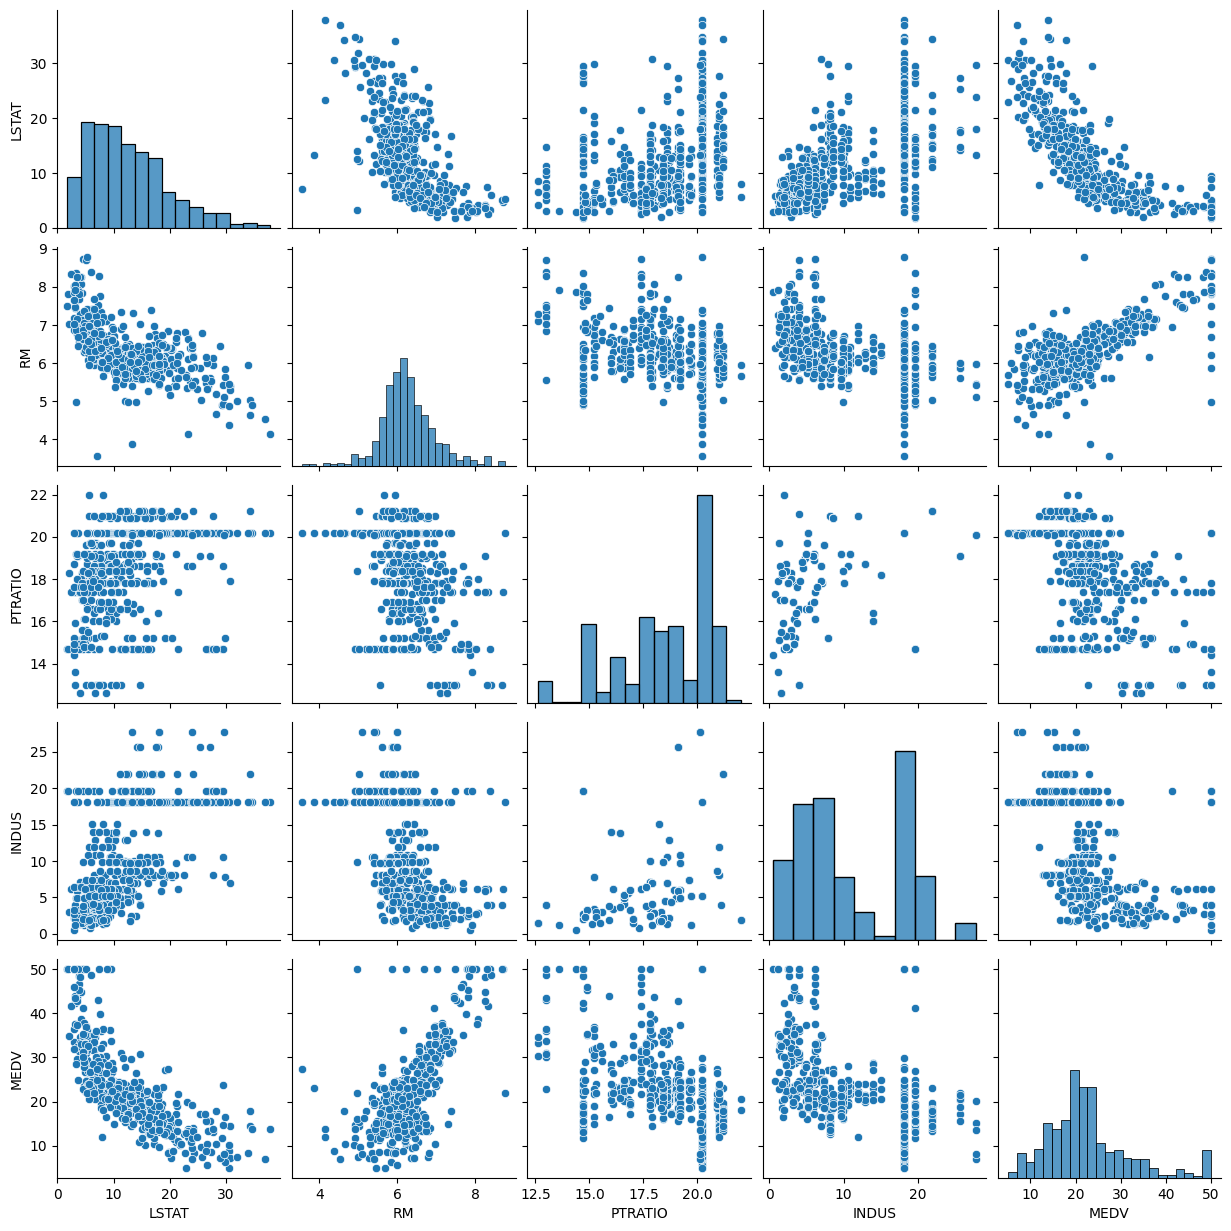

In [13]:
# Pair Plot (4 key features based on correlation strength > 0.4)
key_features = ['LSTAT', 'RM', 'PTRATIO', 'INDUS']  
sns.pairplot(data[[*key_features, 'MEDV']])
plt.show()

### Observations

- **LSTAT vs MEDV**: Shows a **strong curved (non-linear)** negative relationship.
- **RM vs MEDV**: Clear linear upward trend with tight spread.
- **PTRATIO and INDUS**: Both show **weak or noisy** relationships with MEDV but may contribute to multi-feature models.
- These four predictors are **non-redundant** and offer significant explanatory variance.


---

### 6.2 Multicollinearity Detection

Identify feature pairs with high correlation (> 0.7).


In [14]:
# Feature-Feature correlation (multicollinearity)
feature_corr = data.corr()
print("\nFeature-Feature Correlation Matrix (absolute values > 0.7):")
high_corr = np.abs(feature_corr) > 0.7
for col in feature_corr.columns:
    correlated = feature_corr.index[high_corr[col] & (feature_corr.index != col)]
    if len(correlated) > 0:
        print(f"{col} is highly correlated with: {', '.join(correlated)}")


Feature-Feature Correlation Matrix (absolute values > 0.7):
INDUS is highly correlated with: NOX, DIS, TAX
NOX is highly correlated with: INDUS, AGE, DIS
AGE is highly correlated with: NOX, DIS
DIS is highly correlated with: INDUS, NOX, AGE
RAD is highly correlated with: TAX
TAX is highly correlated with: INDUS, RAD
LSTAT is highly correlated with: MEDV
MEDV is highly correlated with: LSTAT


In [15]:
print(corr_matrix['MEDV'].sort_values(ascending=False))

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64


---

### 6.3 Feature Selection

Drop features with low correlation to MEDV and high inter-correlation (e.g., RAD).


In [16]:
# Identify features to drop
# Criteria: |correlation with MEDV| < 0.2 or one of highly correlated pairs
feature_target_corr = corr_matrix['MEDV']
low_corr_features = feature_target_corr[abs(feature_target_corr) < 0.2].index.tolist()
print(f"\nFeatures with low correlation to MEDV (|corr| < 0.2): {low_corr_features}")


Features with low correlation to MEDV (|corr| < 0.2): ['CHAS']


In [17]:
# Drop one feature from highly correlated pairs 
features_to_drop = low_corr_features + ['RAD']  # - Multicollinearity suggests dropping `RAD` due to high correlation with `TAX` (which has stronger correlation with `MEDV`).
print(f"Features to drop: {features_to_drop}")

Features to drop: ['CHAS', 'RAD']


---

## 7. Data Preprocessing

### 7.1 Log Transformation of Skewed Features


In [18]:
# Log-transform skewed features based on EDA (CRIM, ZN, TAX, LSTAT)
data_log = data.copy()
skewed_features = ['CRIM', 'ZN', 'TAX', 'LSTAT' ]
for feature in skewed_features:
    data_log[feature] = np.log1p(data_log[feature])  # log1p handles zero values

In [19]:
features_to_drop = ['CHAS', 'RAD']
print(f"Dropping features: {features_to_drop}")
X = data.drop(columns=features_to_drop)

Dropping features: ['CHAS', 'RAD']


---

### 7.2 Data Splitting and Standardization


In [20]:
# Define features (X) and target (y)
X = data.drop('MEDV', axis=1)
y = data['MEDV']

In [21]:
# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Standardize features (fit on training data only, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

## 8. Model Building and Evaluation

### 8.1 Decision Tree Regressor


In [23]:
# Decision Tree Model with tuning to reduce overfitting
dt_model = DecisionTreeRegressor(max_depth=3, min_samples_split=15, random_state=42)
dt_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_split=15, random_state=42)

In [24]:
y_pred_test_dt = dt_model.predict(X_test_scaled)
test_mse_dt = mean_squared_error(y_test, y_pred_test_dt)
test_rmse_dt = np.sqrt(test_mse_dt)
test_mae_dt = mean_absolute_error(y_test, y_pred_test_dt)
test_r2_dt = r2_score(y_test, y_pred_test_dt)

In [25]:
print(f"Mean Squared Erro: {test_mse_dt:.2f}")
print(f"Root Mean Squared Erro: {test_rmse_dt:.2f}")
print(f"Mean Absolute Erro: {test_mae_dt:.2f}")
print(f"R²: {test_r2_dt:.2f}")

Mean Squared Erro: 16.77
Root Mean Squared Erro: 4.09
Mean Absolute Erro: 3.18
R²: 0.77


In [26]:
# Actual vs Predicted DataFrame for Decision Tree
dt_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_dt})
print("\nDecision Tree - Actual vs Predicted Values:")
dt_results.head(10)  # Showing first 10 rows as example


Decision Tree - Actual vs Predicted Values:


,Actual,Predicted
173,23.6,22.899497
274,32.4,22.899497
491,13.6,17.061842
72,22.8,22.899497
452,16.1,17.061842
76,20.0,22.899497
316,17.8,17.061842
140,14.0,17.061842
471,19.6,22.899497
500,16.8,22.899497


In [30]:
feature_names = X.columns

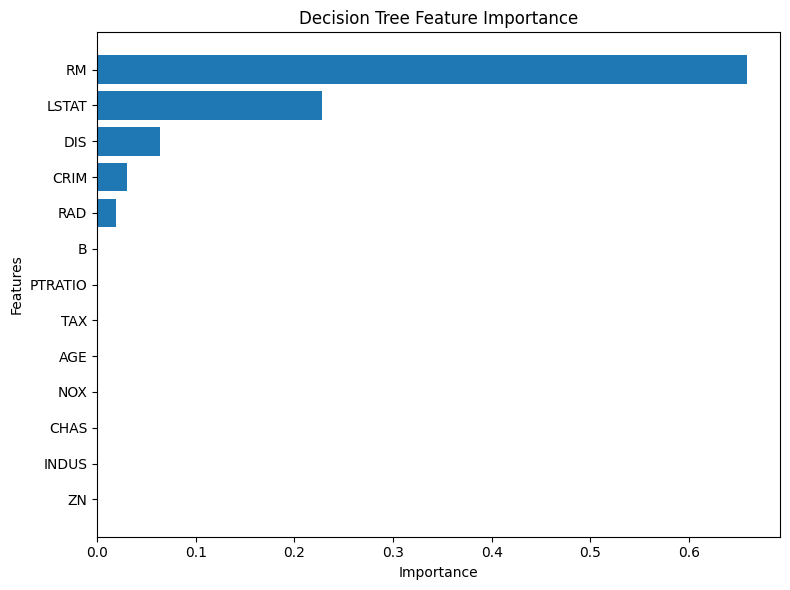

In [33]:
dt_importances = dt_model.feature_importances_
indices_dt = np.argsort(dt_importances)[0::]  
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), dt_importances[indices_dt])
plt.yticks(range(len(feature_names)), np.array(feature_names)[indices_dt])
plt.title('Decision Tree Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

---

### 8.2 Random Forest Regressor


In [34]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [35]:
# Random Forest Evaluation
y_pred_test_rf = rf_model.predict(X_test_scaled)
test_mse_rf = mean_squared_error(y_test, y_pred_test_rf)
test_rmse_rf = np.sqrt(test_mse_rf)
test_mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

In [36]:
print(f"Mean Squared Error: {test_mse_rf:.2f}")
print(f"Root Mean Squared Error: {test_rmse_rf:.2f}")
print(f"Mean Absolute Error: {test_mae_rf:.2f}")
print(f"R²: {test_r2_rf:.2f}")

Mean Squared Error: 7.91
Root Mean Squared Error: 2.81
Mean Absolute Error: 2.04
R²: 0.89


In [37]:
# Actual vs Predicted DataFrame for Random Forest
rf_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_rf})
print("\nRandom Forest - Actual vs Predicted Values:")
rf_results.head(10)  # Showing first 10 rows as example


Random Forest - Actual vs Predicted Values:


,Actual,Predicted
173,23.6,22.839
274,32.4,30.689
491,13.6,16.317
72,22.8,23.510
452,16.1,16.819
76,20.0,21.425
316,17.8,19.358
140,14.0,15.620
471,19.6,21.091
500,16.8,21.073


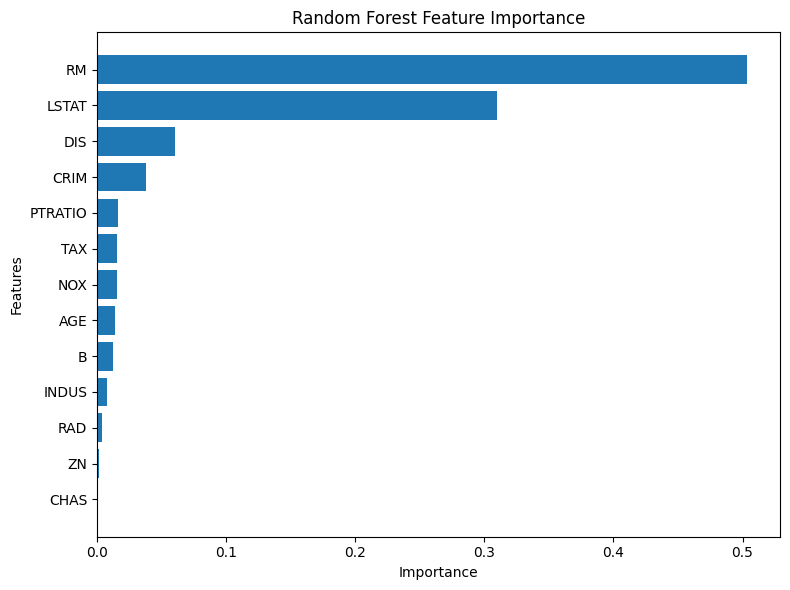

In [53]:
# Random Forest Feature Importance Plot
rf_importances = rf_model.feature_importances_
indices_rf = np.argsort(rf_importances)[0::]
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), rf_importances[indices_rf])
plt.yticks(range(len(feature_names)), np.array(feature_names)[indices_rf])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

---

## 8.3 Ridge Regression from Scratch

Implementing Ridge Regression using closed-form solution with L2 regularization.


In [39]:
import numpy as np

class RidgeRegression:
    def __init__(self, alpha=1.0):
        """
        Initialize Ridge Regression model.
        
        Parameters:
        alpha : float, default=1.0
            Regularization strength; must be a positive float.
        """
        self.alpha = alpha
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        """
        Fit the Ridge Regression model.
        
        Parameters:
        X : array-like of shape (n_samples, n_features)
            Training data
        y : array-like of shape (n_samples,)
            Target values
            
        Returns:
        self : object
            Returns self.
        """
        # Convert inputs to numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        # Add column of ones for bias term
        X_with_bias = np.c_[X, np.ones(X.shape[0])]
        
        # Calculate weights using closed-form solution:
        # w = (X^T X + alpha*I)^(-1) X^T y
        n_features = X_with_bias.shape[1]
        identity = np.eye(n_features)
        # Don't regularize the bias term
        identity[-1, -1] = 0
        
        # Compute (X^T X + alpha*I)^(-1) X^T y
        XTX = X_with_bias.T @ X_with_bias
        regularized = XTX + self.alpha * identity
        inverse = np.linalg.inv(regularized)
        coefficients = inverse @ X_with_bias.T @ y
        
        # Split coefficients into weights and bias
        self.weights = coefficients[:-1]
        self.bias = coefficients[-1]
        
        return self
    
    def predict(self, X):
        """
        Predict using the Ridge Regression model.
        
        Parameters:
        X : array-like of shape (n_samples, n_features)
            Samples to predict.
            
        Returns:
        y_pred : array-like of shape (n_samples,)
            Predicted values.
        """
        if self.weights is None or self.bias is None:
            raise ValueError("Model must be fitted before prediction")
            
        X = np.array(X)
        return X @ self.weights + self.bias

In [40]:
# Instantiate and fit the model
model = RidgeRegression(alpha=1.0)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate predictions
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error on test set: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error on test set: 24.3129
Root Mean Squared Error (RMSE): 4.9308
R² Score: 0.6685


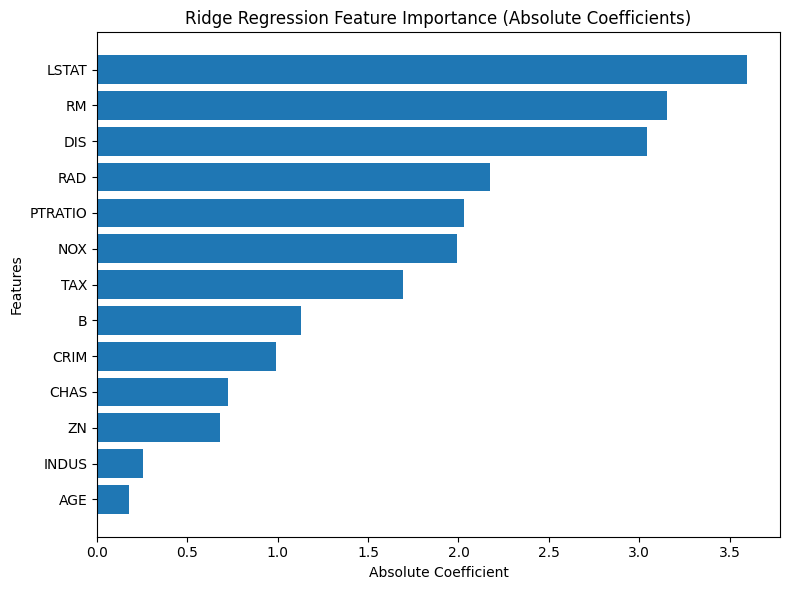

In [51]:
# Ridge Regression Feature Importance Plot (using absolute coefficients)
ridge_coefficients = np.abs(model.weights)
indices_ridge = np.argsort(ridge_coefficients)[0::]
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), ridge_coefficients[indices_ridge])
plt.yticks(range(len(feature_names)), np.array(feature_names)[indices_ridge])
plt.title('Ridge Regression Feature Importance (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [42]:
# Create DataFrame for actual vs predicted
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Display first 5 rows of the DataFrame
results_df.head()

,Actual,Predicted
173,23.6,28.973076
274,32.4,35.974292
491,13.6,14.932546
72,22.8,25.021310
452,16.1,18.764462


## 8.4 Gradient Boosting Regressor

In [43]:
# Gradient Boosting Regressor with tuning to reduce overfitting
gbt_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, min_samples_split=15, learning_rate=0.1, random_state=42)
gbt_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(min_samples_split=15, random_state=42)

In [44]:
# Make predictions on the test set
y_pred_test_gbt = gbt_model.predict(X_test_scaled)

In [45]:
# Calculate evaluation metrics
test_mse_gbt = mean_squared_error(y_test, y_pred_test_gbt)
test_rmse_gbt = np.sqrt(test_mse_gbt)
test_mae_gbt = mean_absolute_error(y_test, y_pred_test_gbt)
test_r2_gbt = r2_score(y_test, y_pred_test_gbt)

In [46]:
# Print evaluation metrics
print(f"Mean Squared Error: {test_mse_gbt:.2f}")
print(f"Root Mean Squared Error: {test_rmse_gbt:.2f}")
print(f"Mean Absolute Error: {test_mae_gbt:.2f}")
print(f"R²: {test_r2_gbt:.2f}")

Mean Squared Error: 6.35
Root Mean Squared Error: 2.52
Mean Absolute Error: 1.93
R²: 0.91


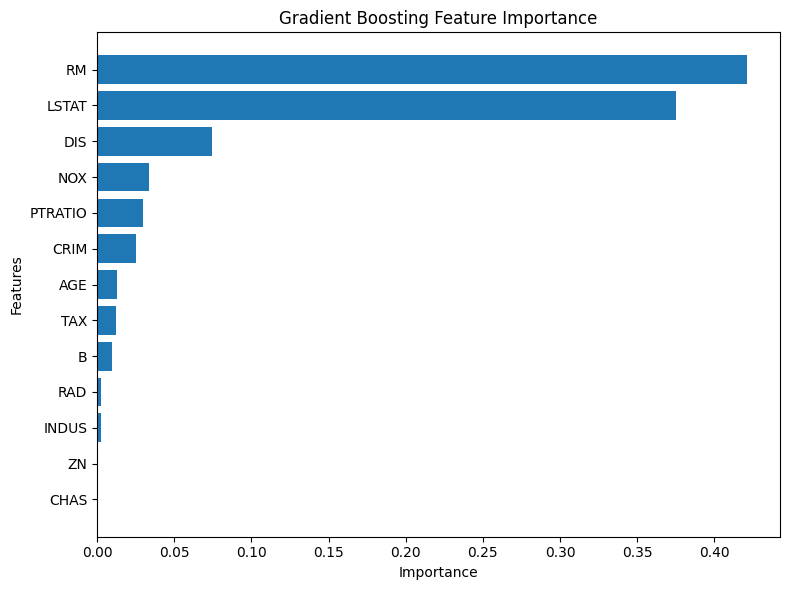

In [48]:
gbt_importances = gbt_model.feature_importances_
indices_gbt = np.argsort(gbt_importances)[0::]
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), gbt_importances[indices_gbt])
plt.yticks(range(len(feature_names)), np.array(feature_names)[indices_gbt])
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

---

### 9 Model Comparison

Compare Decision Tree, Random Forest and Ridge Regression models using error metrics and R².


In [52]:
# Create comparison DataFrame
data = {
    'Model': ['Decision Tree', 'Random Forest', 'Ridge Regression', 'Gradient Boosting'],
    'MSE': [test_mse_dt, test_mse_rf, mse, test_mse_gbt],
    'RMSE': [test_rmse_dt, test_rmse_rf, rmse, test_rmse_gbt],
    'MAE': [test_mae_dt, test_mae_rf, mean_absolute_error(y_test, y_pred), test_mae_gbt],
    'R²': [test_r2_dt, test_r2_rf, r2, test_r2_gbt]
}

comparison_df = pd.DataFrame(data)

# Display the DataFrame
comparison_df

,Model,MSE,RMSE,MAE,R²
0,Decision Tree,16.766567,4.094700,3.177735,0.771366
1,Random Forest,7.912745,2.812960,2.041078,0.892100
2,Ridge Regression,24.312904,4.930812,3.185724,0.668462
3,Gradient Boosting,6.347415,2.519408,1.932449,0.913445


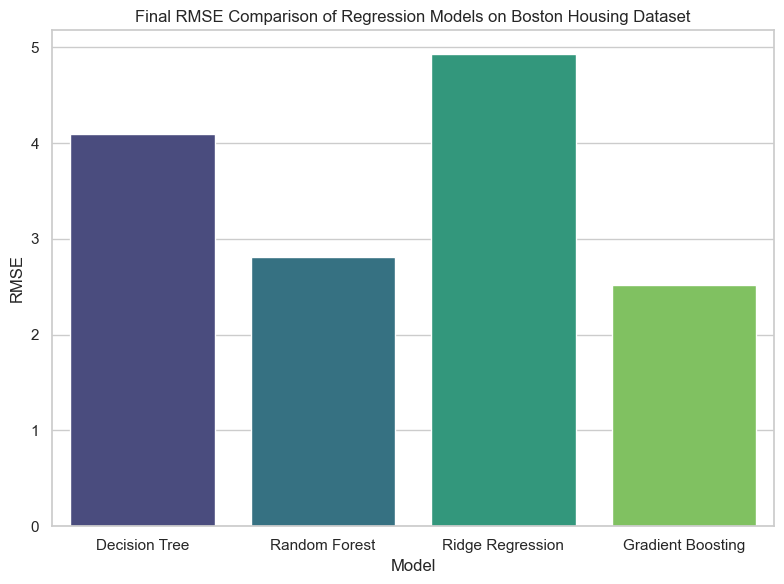

In [58]:
# Final RMSE Comparison Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract RMSE data from comparison_df
rmse_data = comparison_df[['Model', 'RMSE']].copy()

# Set plot style
sns.set(style='whitegrid')

# Create the RMSE comparison plot
plt.figure(figsize=(8, 6))
sns.barplot(data=rmse_data, x='Model', y='RMSE', palette='viridis')
plt.title('Final RMSE Comparison of Regression Models on Boston Housing Dataset')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.tight_layout()
plt.show()


Text(0.5, 0, 'Model')

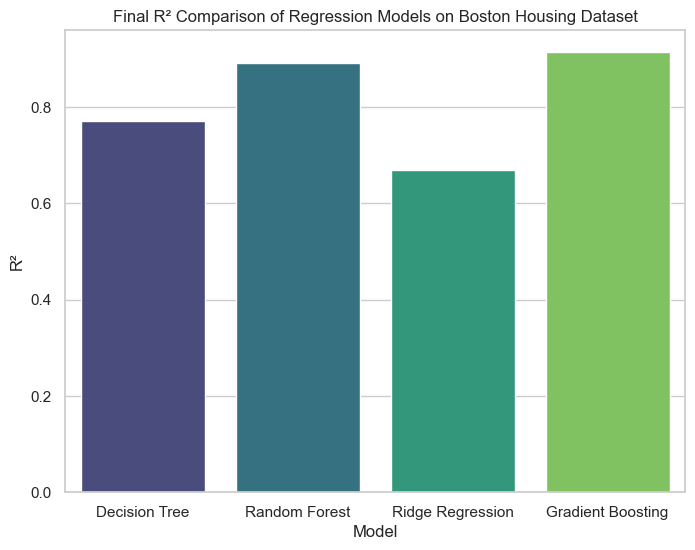

In [60]:
# Extract R² data from comparison_df
r2_data = comparison_df[['Model', 'R²']].copy()

# Set plot style
sns.set(style='whitegrid')

# Create the R² comparison plot
plt.figure(figsize=(8, 6))
sns.barplot(data=r2_data, x='Model', y='R²', palette='viridis')
plt.title('Final R² Comparison of Regression Models on Boston Housing Dataset')
plt.ylabel('R²')
plt.xlabel('Model')


### Interpretation of Results

- **Gradient Boosting Regressor** yielded the lowest error values across all metrics, indicating the highest predictive precision:
  - The MSE of 6.35 and RMSE of 2.52 suggest excellent generalization performance.
  - Its MAE of 1.93 indicates consistent accuracy with minimal average deviation from actual values.
  - The R² score of 0.913 signifies that the model explains over 91.3% of the variance in the target variable (MEDV), making it the most effective model.

- **Random Forest Regressor** performed very well, though slightly below Gradient Boosting:
  - With an MSE of 7.91 and RMSE of 2.81, it demonstrates strong generalization capability.
  - Its MAE of 2.04 and R² score of 0.892 indicate robust accuracy and explain nearly 89.2% of the variance, making it a close contender.
  - The slight edge of Gradient Boosting suggests ensemble methods with tuning (e.g., learning rate) can further optimize performance.

- **Decision Tree Regressor** performed reasonably well but lagged behind the ensemble methods:
  - With an R² score of 0.771, it captures approximately 77.1% of the variance in the target.
  - The higher error metrics (MSE: 16.77, RMSE: 4.09, MAE: 3.18) indicate greater sensitivity to data partitions and potential overfitting, especially with the tuned parameters.

- **Ridge Regression**, despite being a regularized linear model, showed the poorest performance:
  - The highest RMSE (4.93) and lowest R² (0.668) reflect the inability of linear models to capture the non-linear relationships present in the dataset.
  - The MAE (~3.19) was also higher than the other models, further confirming reduced prediction accuracy.

### Conclusion

Based on the comparative analysis of all models, **Gradient Boosting Regressor** is conclusively the best-performing model for the Boston Housing dataset.  
- It offers superior accuracy, robustness, and the highest explanatory power (R² = 0.913), making it the optimal choice for deployment or downstream tasks.

- **Random Forest Regressor** remains a strong alternative, with excellent performance (R² = 0.892) and robustness, suitable as a backup or when computational simplicity is preferred over slight performance gains.

- **Ridge Regression** should be retained only as a linear interpretability benchmark, given its lower performance across all metrics.

- **Decision Tree** may serve as a simplified baseline or interpretable approximation, though its higher errors suggest it’s less reliable than the ensemble methods.